In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"

2025-09-19 21:54:33.070 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: G:\Projects\Fusion-3D-CNN


Project root added to path: g:\Projects\Fusion-3D-CNN


In [2]:
import numpy as np
from pathlib import Path
files = list(Path(BREPNET_NPZ_DIR).glob("*.npz"))

feats = np.load(files[0], allow_pickle=True)

for k, v in feats.items():
    print(k, v.shape)

face_features (9, 7)
face_point_grids (9, 7, 10, 10)
edge_features (16, 10)
coedge_point_grids (31, 12, 10)
coedge_features (31, 1)
coedge_lcs (31, 4, 4)
coedge_scale_factors (31,)
coedge_reverse_flags (31,)
next (31,)
mate (31,)
face (31,)
edge (31,)


In [3]:
from src.modeling.ssl_graph_brep.data_module.brep_dataset import BRepNPZDataset

dataset = BRepNPZDataset(BREPNET_NPZ_DIR)
print(f"Dataset length: {len(dataset)}")
g = dataset.get(0)
print(g)

for k, v in g.items():
    print(k, v.shape if hasattr(v, "shape") else v)

Dataset length: 129
HeteroData(
  face={
    x=[9, 7],
    uv=[9, 7, 10, 10],
    num_nodes=9,
  },
  edge={
    x=[16, 10],
    num_nodes=16,
  },
  coedge={
    x=[31, 1],
    grid=[31, 12, 10],
    lcs=[31, 4, 4],
    scale=[31],
    reverse=[31],
    num_nodes=31,
  },
  (coedge, next, coedge)={ edge_index=[2, 31] },
  (coedge, mate, coedge)={ edge_index=[2, 31] },
  (coedge, to_face, face)={ edge_index=[2, 31] },
  (coedge, to_edge, edge)={ edge_index=[2, 31] }
)


In [4]:
from src.modeling.ssl_graph_brep.data_module.brep_data_loader import BRepDataModule
data_module = BRepDataModule(BREPNET_NPZ_DIR, batch_size=32, num_workers=0)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
print(batch)

HeteroDataBatch(
  face={
    x=[2546, 7],
    uv=[2546, 7, 10, 10],
    num_nodes=2546,
    batch=[2546],
    ptr=[33],
  },
  edge={
    x=[7040, 10],
    num_nodes=7040,
    batch=[7040],
    ptr=[33],
  },
  coedge={
    x=[14057, 1],
    grid=[14057, 12, 10],
    lcs=[14057, 4, 4],
    scale=[14057],
    reverse=[14057],
    num_nodes=14057,
    batch=[14057],
    ptr=[33],
  },
  (coedge, next, coedge)={ edge_index=[2, 14057] },
  (coedge, mate, coedge)={ edge_index=[2, 14057] },
  (coedge, to_face, face)={ edge_index=[2, 14057] },
  (coedge, to_edge, edge)={ edge_index=[2, 14057] }
)


In [ ]:
from src.modeling.ssl_graph_brep import train


train.run(
    npz_brep_dir=BREPNET_NPZ_DIR,
    batch_size=32,
    epochs=10,
    num_workers=4,
    proj_dim=256,
    lr=3e-4,
    hidden=128,
    tau=0.07,
    lambda_topo_next=1.0,
    lambda_topo_mate=1.0,
    aug_p=0.15,
    topo_tau=0.07,
    weight_decay=1e-3,
    validation_ratio=0.2,
    test_ratio=0.1,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory G:\Projects\Fusion-3D-CNN\models\ssl_brep exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                | Params | Mode 
------------------------------------------------------------
0 | face_enc    | UVNetSurfaceEncoder | 406 K  | train
1 | coedge_enc  | UVNetCurveEncoder   | 159 K  | train
2 | edge_lin    | Linear              | 1.4 K  | train
3 | gnn         | BRepHeteroGNN       | 100 K  | train
4 | projector   | Sequential          | 131 K  | train
5 | scorer_next | BilinearScorer      | 65.5 K | train
6 | scorer_mate | BilinearScorer      | 65.5 K | train
------------------------------------------------------------
929 K     Trainable params
0         Non-trainable params
929 K     Total params
3.7

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000115F12CEF20>
Traceback (most recent call last):
  File "C:\Users\Kaktus\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "C:\Users\Kaktus\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\Kaktus\.conda\envs\brepnet\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kaktus\.conda\envs\brepnet\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


Validation: |          | 0/? [00:00<?, ?it/s]

: 

: 

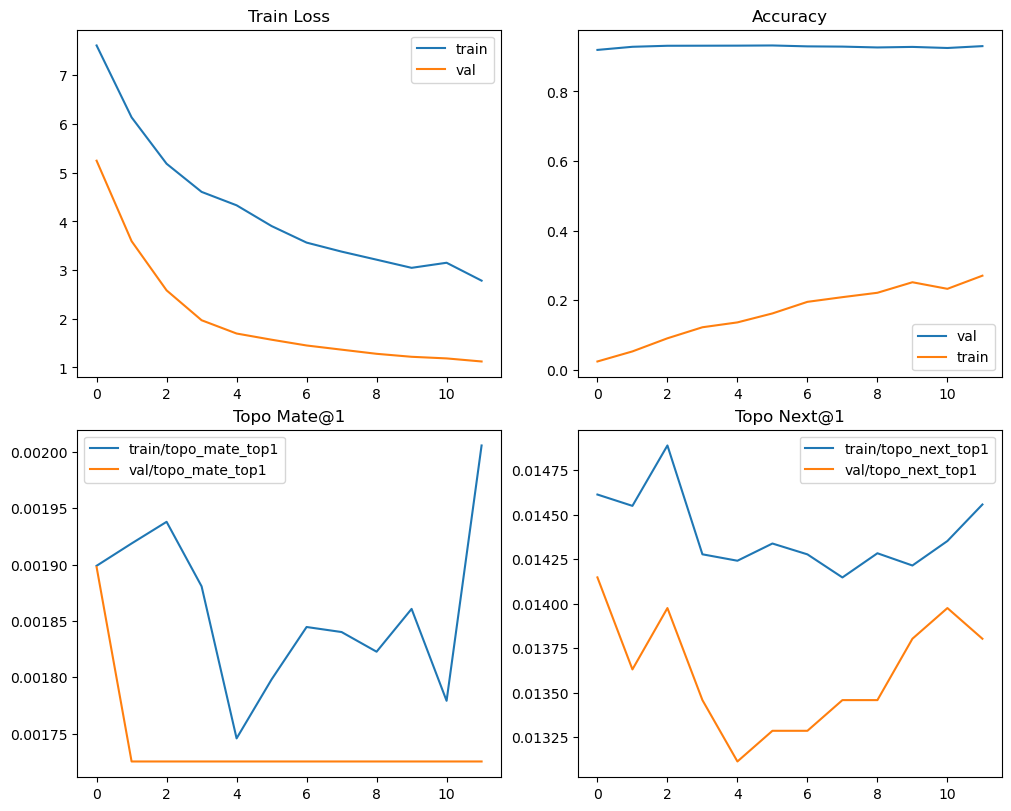

In [5]:
from src.modeling.ssl_graph_brep import plots

metrics_csv = REPORTS_DIR / "ssl_brep" / "version_3" / "metrics.csv"

plots.plot_training_curves(metrics_csv)

In [7]:
from src.modeling.ssl_graph_brep.inference import extract_embeddings, topk_similar, search_by_name

ckpt = MODELS_DIR / "ssl_brep" / "ssl-brep-epoch=05-val_infoNCE_acc=0.932.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "42. Ejector"
data_dir = Path(BREPNET_NPZ_DIR)
ids, E = extract_embeddings(ckpt, data_dir)

topk_idx = topk_similar(E, k=10)
for i, nn_idx in enumerate(topk_idx[:15]):
    print("Query:", ids[i])
    print("Top-10:", [ids[j] for j in nn_idx])
    print("---")

Query: 42. Ejector-01.prt
Top-10: ['42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-02', '42. Ejector.prt', '42. Ejector-04.prt', '42. Ejector-03.prt', '42. Ejector-08.prt', '42. Ejector-07.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-02
Top-10: ['42. Ejector-02', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-03.prt', '42. Ejector.prt', '42. Ejector-04.prt', '42. Ejector-08.prt', '42. Ejector-07.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-03.prt
Top-10: ['42. Ejector-03.prt', '42. Ejector-04.prt', '42. Ejector-02', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-09.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-10.prt', 'Зацеп трубки направляющий 7.prt']
---
Query: 42. Ejector-04.prt
Top-10: ['42. Ejector-04.prt', '42. Ejector-03.prt', '42. Ejector-01.prt', '42. Ejector-09.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-02', '42. Ejector.prt', '42. Ejector-10.prt', 'Зацеп тр

In [12]:
import pandas as pd

class_name = "Защелка 6"

# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / class_name

ids, E = extract_embeddings(model_ckpt=ckpt, data_dir=BREPNET_NPZ_DIR)


results = search_by_name(ids, E, query_name=f"{class_name}", include_self=True, max_print=30)

# report_name = 'graph_report.xlsx'

# df = pd.DataFrame(results, columns=['q', 'acc', 'name'] )
# report_path = REPORTS_DIR / report_name  # 'graph_report.xlsx'
# mode = 'a' if Path(report_path).exists() else 'w'  # append или создать
# with pd.ExcelWriter(report_path, engine="openpyxl", mode=mode) as writer:
#     df.to_excel(writer, sheet_name=class_name, index=False)


Запрос: Защелка 6.prt
   1. 100.00%  Защелка 6.prt
   2.  99.98%  Защелка 8.prt
   3.  99.98%  Защелка 9.prt
   4.  99.93%  Защелка 7.prt
   5.  99.49%  Защелка 5.prt
   6.  99.49%  Защелка 4.prt
   7.  98.87%  Защелка 3.prt
   8.  98.60%  Защелка.prt
   9.  98.55%  Защелка 1.prt
  10.  98.46%  Колодка приклада 7.prt
  11.  98.42%  Колодка прицельная 1.prt
  12.  98.42%  Колодка прицельная.prt
  13.  98.42%  Колодка приклада 8.prt
  14.  98.41%  Колодка прицельная 3.prt
  15.  98.41%  Колодка прицельная 4.prt
  16.  98.37%  Колодка прицельная 5.prt
  17.  98.35%  Колодка прицельная 6.prt
  18.  98.31%  Колодка приклада 9.prt
  19.  98.30%  Колодка прицельная 7.prt
  20.  98.27%  Колодка прицельная 8.prt
  21.  98.20%  Колодка приклада 6.prt
  22.  98.19%  43. Extractor-09.prt
  23.  98.15%  Защелка 10.prt
  24.  98.13%  43. Extractor-04.prt
  25.  98.13%  Колодка прицельная 2.prt
  26.  98.12%  Затвор 4.prt
  27.  98.12%  Колодка прицельная 10.prt
  28.  98.09%  Колодка прицельная 9.p